In [1596]:
import datetime as dt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from yahoo_fin import stock_info as si

In [1274]:
def get_price(stock):
    try:
        return np.round(si.get_live_price(stock), decimals = 2)
    except:
        print(f"{stock.upper()} is not a valid ticker")
        
def get_data(stock, start, end):
    try:
        stock_data = pdr.data.DataReader(
            stock,
            "yahoo",
            start=start,
            end= end 
        )
        return stock_data["Adj Close"]
    except pdr._utils.RemoteDataError:
        print(f'No data found for {stock}.')

In [1]:
class Ledger:
    def __init__(self):
        self.transactions = {}
        self.holdings = {"USD": 0}
        
    def get_holdings(self):
        return self.holdings
    
    def get_transactions(self):
        return self.transactions
    
    def register_transaction(self, transaction, symbol, shares, date):
        pps = np.round(
            get_data(
                symbol, 
                date,
                dt.datetime.now().date().strftime("%Y-%m-%d")).values[0],
            decimals = 2)
        total = pps*shares
        transaction_id = len(ledger.get_transactions())
        self.transactions.update({
                transaction_id: {
                    "type" : transaction,
                    "date": date,
                    "symbol": symbol.upper(),
                    "shares": shares,
                    "pps": pps,
                    "total" : total,
                } 
            })
        holdings = self.get_holdings()
        if transaction == "buy":
            if symbol in holdings.keys():
                holding = holdings[symbol]
                holdings["USD"] -= total if holdings["USD"] > total else holdings["USD"]
                holding["pps"] = (
                    (holding["pps"]*holding["shares"] + total) / 
                    (holding["shares"] + shares))
                holding["shares"] += shares
            else:
                holdings.update({
                    symbol: {
                        "shares": shares,
                        "pps": pps
                    }
                })
        if transaction == "sell":
            holding = holdings[symbol]
            holdings["USD"] += total
            holding["shares"] -= shares
            if holding["shares"] == 0:
                del holdings[symbol]
    
    def get_ts(self):
        #get_portfolio constructs the time series of the portfolio between two trading days
        def get_portfolio(portfolio, start, end):
            series = pd.Series(dtype="float64")
            for symbol in portfolio.keys():
                s = get_data(symbol, start, end) * portfolio[symbol]
                if symbol == "USD":
                    continue
                series = series.add(s, fill_value = 0)
            return series + portfolio["USD"]
        transactions = self.get_transactions()
        dates = [transactions[t]["date"] for t in transactions] + [dt.datetime.now().date().strftime("%Y-%m-%d")]
        portfolio = {"USD": 0}
        series = pd.Series(dtype="float64")
        for t in transactions:
            tr = transactions[t]
            adj = 0
            if tr["type"] == "buy":
                adj = -1 * (tr["total"] if portfolio["USD"] > tr["total"] else portfolio["USD"])
                if tr["symbol"] in portfolio:
                    portfolio[tr["symbol"]] += tr["shares"] 
                else:
                    portfolio.update({tr["symbol"] : tr["shares"]})
            if tr["type"] == "sell":
                portfolio["USD"] += tr["total"]
                portfolio[tr["symbol"]] -= tr["shares"] 
            add = (tr["total"] - portfolio["USD"]) if tr["total"] > portfolio["USD"] else 0
            portfolio["USD"] += adj
            s = get_portfolio(portfolio, dates[t], dates[t+1])
            series = (series[:s.index[0]] + add).append(s) 
        #return the series with duplicated index values removed
        return pd.Series([series.loc[x] 
             if isinstance(series.loc[x], np.float64) 
             else series.loc[x].values[0] for x in series.index.unique()],
                         index = series.index.unique())

In [1672]:
ledger = Ledger()

In [1673]:
ledger.register_transaction("buy", "XOM", 75, "2016-01-01")
ledger.register_transaction("buy", "BAC", 100, "2016-06-01")
ledger.register_transaction("sell", "XOM", 25, "2016-09-01")
ledger.register_transaction("buy", "AAPL", 150, "2017-01-01")
ledger.register_transaction("sell", "BAC", 40, "2017-03-01")
ledger.register_transaction("buy", "CAT", 100, "2017-06-01")
ledger.register_transaction("buy", "MSFT", 25, "2018-01-01")
ledger.register_transaction("sell", "AAPL", 50, "2018-03-01")
ledger.register_transaction("buy", "AMZN", 5, "2018-06-01")
ledger.register_transaction("buy", "IBM", 50, "2019-01-01")
ledger.register_transaction("buy", "TGT", 50, "2019-06-01")
ledger.register_transaction("sell", "AMZN", 3, "2019-09-01")
ledger.register_transaction("buy", "SPY", 20, "2020-03-01")
ledger.register_transaction("sell", "TGT", 10, "2020-09-01")

In [1717]:
holdings = ledger.get_holdings()
df = pd.DataFrame(holdings).transpose()
df["pps"].loc["USD"] = 1
df["current_price"] = [df.pps.loc["USD"]] + [get_price(x) for x in df.index[1:]]
df["equity"] = df.current_price * df.shares
df["return"] = np.round((df.current_price - df.pps)/ df.pps, decimals = 4)
df

,shares,pps,current_price,equity,return
USD,11603.57,1.00,1.00,11603.57,0.0000
XOM,50.00,59.27,62.52,3126.00,0.0548
BAC,60.00,13.44,41.77,2506.20,2.1079
AAPL,100.00,27.41,127.35,12735.00,3.6461
CAT,100.00,95.34,220.49,22049.00,1.3127
MSFT,25.00,82.00,257.55,6438.75,2.1409
AMZN,2.00,1641.54,3342.71,6685.42,1.0363
IBM,50.00,101.94,151.15,7557.50,0.4827
TGT,40.00,79.67,232.73,9309.20,1.9212
SPY,20.00,302.43,423.72,8474.40,0.4011


In [1711]:
import plotly.graph_objects as go

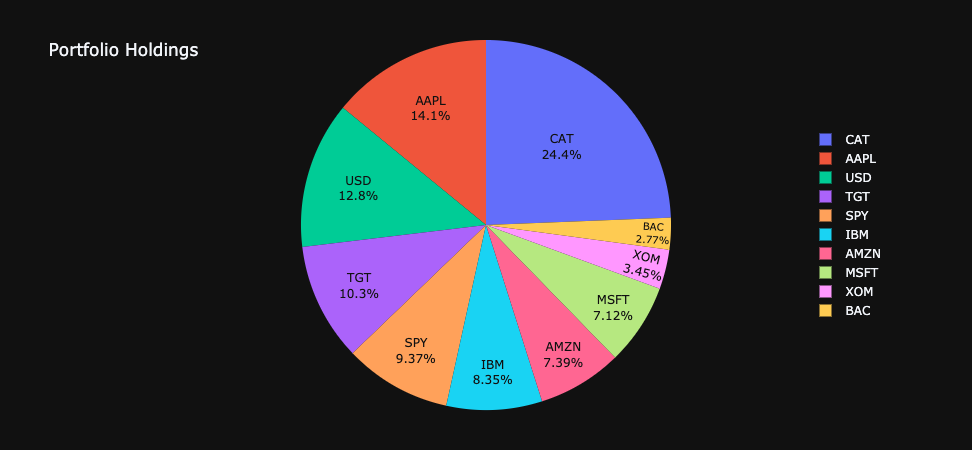

In [1719]:
fig = go.Figure(data = [
    go.Pie(
        values = df.equity, 
        labels = df.index,
        textposition="inside", 
        textinfo="percent+label",
        textfont_color= "#111111",
    )])
fig.update_layout(
    template = "plotly_dark",
    title = {
        "text" : "Portfolio Holdings",
        "y" : .875,
        "x" : .05,
        "xanchor" : "left",
        "yanchor" : "bottom"
    },
    margin = dict(l = 60, t = 40, r = 60, b = 40),
    legend = dict(yanchor = "middle", y = .5, xanchor = "left", x = .875),
)
fig.show()

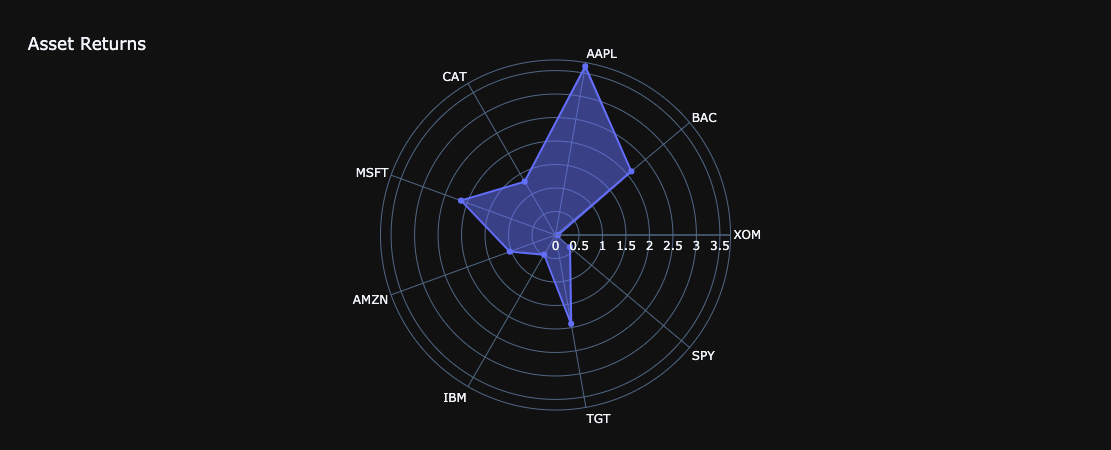

In [1736]:
fig = go.Figure(data = go.Scatterpolar(
    r = df["return"][1:].values,
    theta = df.index[1:],
    fill = 'toself',
))

fig.update_layout(
    polar = dict(radialaxis = dict(visible = True)), 
    margin = dict(l = 60, t = 60, r = 60, b = 40),
    template = "plotly_dark",
    title = {
        "text" : "Asset Returns",
        "y" : .89,
        "x" : .025,
        "xanchor" : "left",
        "yanchor" : "bottom"
    },
)

fig.show()

In [1739]:
transactions = ledger.get_transactions()
df = pd.DataFrame(transactions).transpose()
df.loc[df.type == "sell", "total"] = df.loc[df.type == "sell", "total"] * -1
df

,type,date,symbol,shares,pps,total
0,buy,2016-01-01,XOM,75,59.27,4445.25
1,buy,2016-06-01,BAC,100,13.44,1344
2,sell,2016-09-01,XOM,25,68.19,-1704.75
3,buy,2017-01-01,AAPL,150,27.41,4111.5
4,sell,2017-03-01,BAC,40,23.33,-933.2
5,buy,2017-06-01,CAT,100,95.34,9534
6,buy,2018-01-01,MSFT,25,82,2050
7,sell,2018-03-01,AAPL,50,42.14,-2107
8,buy,2018-06-01,AMZN,5,1641.54,8207.7
9,buy,2019-01-01,IBM,50,101.94,5097


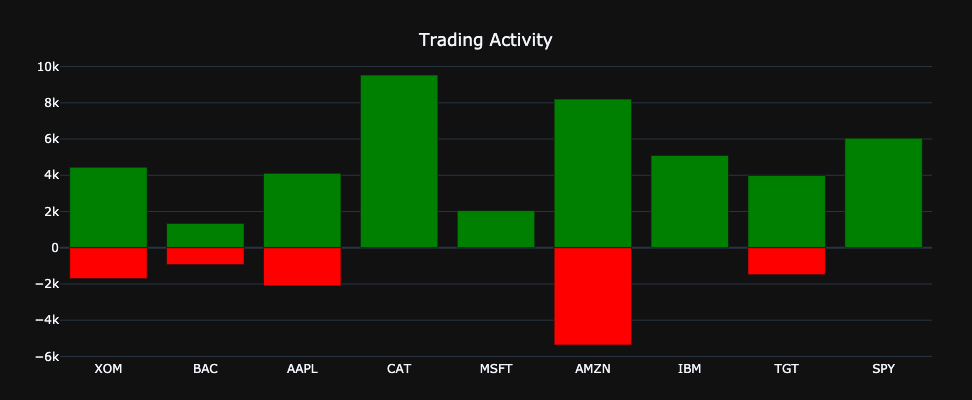

In [1745]:
fig = go.Figure([
      go.Bar(
        x = df.symbol, 
        y = df.total,
        text = df.date,
        meta = df.shares,
        customdata = df.pps,
        marker_color= ["green" if x == "buy" else "red" for x in df.type],
        hovertemplate = ("Total: $%{y:,.2f}" +
                         "<br>Shares: %{meta}" +
                         "<br>PPS: $%{customdata:,.2f}<extra></extra>" + 
                         "<br>Date: %{text}"))
    ],
)
fig.update_layout(
    template = "plotly_dark",
    title = {
        "text" : "Trading Activity",
        "y" : .9,
        "x" : .5,
        "xanchor" : "center",
        "yanchor" : "middle",
    },
    height = 400,
    margin = dict(t = 60, l = 60, r = 40, b = 40)
)
fig.show()

In [1697]:
ts = ledger.get_ts()

In [1698]:
ts

2016-01-04    34707.348970
2016-01-05    34745.228056
2016-01-06    34707.923464
2016-01-07    34636.757807
2016-01-08    34548.375658
                  ...     
2021-06-07    81516.469698
2021-06-08    82003.971254
2021-06-09    81484.948770
2021-06-10    80707.898630
2021-06-11    80399.874170
Length: 1370, dtype: float64

In [1750]:
spy = get_data("SPY", ts.index[0], ts.index[-1])

df = pd.DataFrame({"Portfolio" : ts.values, "SPY" : spy[ts.index[0]:].values}, index = ts.index)
df.Portfolio = np.round((df.Portfolio - df.Portfolio[0]) / df.Portfolio[0], decimals = 4)
df.SPY = np.round((df.SPY - df.SPY[0]) / df.SPY[0], decimals = 4)

df

,Portfolio,SPY
2016-01-04,0.0000,0.0000
2016-01-05,0.0011,0.0017
2016-01-06,0.0000,-0.0109
2016-01-07,-0.0020,-0.0347
2016-01-08,-0.0046,-0.0453
...,...,...
2021-06-07,1.3487,1.3208
2021-06-08,1.3627,1.3213
2021-06-09,1.3478,1.3178
2021-06-10,1.3254,1.3286


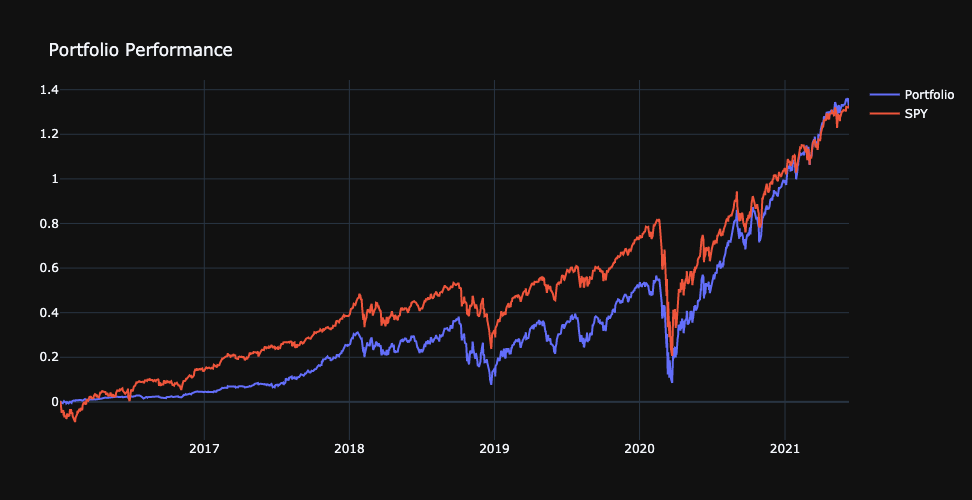

In [1751]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = df.index, 
    y = df.Portfolio,
    mode = "lines",
    name = "Portfolio"
))
fig.add_trace(go.Scatter( 
    x = df.index, 
    y = df.SPY,
    mode = "lines",
    name = "SPY"
))
fig.update_layout(
    title = {
        "text" : f'Portfolio Performance',
        "y": .9,
        "x": .05,
        "xanchor": "left",
        "yanchor": "middle"
    },
    template = "plotly_dark",
    margin = dict(l = 60, t = 80, r = 60, b = 60),
    height = 500
)
fig.show()